<a href="https://colab.research.google.com/github/hfarruda/deeplearningtutorial/blob/master/deepLearning_RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Restricted Boltzmann Machine (RBM)

This example is part of the [*Deep Learning Tutorial*](https://github.com/hfarruda/deeplearningtutorial), authored by Henrique F. de Arruda, Alexandre Benatti, César Comin, and Luciano da Fontoura Costa. This code is not suitable for other data and/or applications, which will require modifications in the structure and parameters. This code has absolutely no warranty.

If you publish a paper related on this material, please cite:

H. F. de Arruda, A. Benatti, C. H. Comin, L. da F. Costa, "Learning Deep Learning (CDT-15)," 2019.

This is the fourth example of deep learning implementation. Here we use a RMB network to provide a recommendation system of CDs and vinyls.

First of all, we import the necessary libraries. Here we opt for using Keras (using TensorFlow backend).

In [ ]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd 
from sklearn.neural_network import BernoulliRBM
import matplotlib.pyplot as plt
import urllib.request
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


The following code downlods a dataset regarding the ratings of CDs and vinyls from the Amazon website ([link](http://snap.stanford.edu/data/amazon/productGraph/)).
These data is divided into four columns, as follows: user id, item id, rating, and timestamp. The latter was removed from our analysis.

In [ ]:
main_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/"
file_name = "ratings_CDs_and_Vinyl.csv"
url = main_url + file_name
col_names = ["user", "item", "rating", "timestamp"]
urllib.request.urlretrieve(url, file_name)
musical_instruments_reviews = pd.read_csv(file_name, names = col_names)

In the following, we preprocess the dataset.

In [ ]:
#Defining dataset variables
rating = musical_instruments_reviews["rating"].to_numpy()
rating /= np.max(rating)

users = musical_instruments_reviews["user"].to_numpy()

label_encoder = LabelEncoder()
items = musical_instruments_reviews["item"].to_numpy()
items = label_encoder.fit_transform(items)

In order to reduce the time for running this tutorial, we reduced the number of items.

In [ ]:
number_of_items = 6

#Finding lines to erase
unique_items, item_counts = np.unique(items, return_counts=True)
item2count = dict(zip(unique_items, item_counts))
item_count = sorted(item2count.items(), key=lambda x: x[1])[::-1]
item_count = item_count[0:number_of_items]
selected_items = [item for item, count in item_count]

#keeping only the most frequent items
keep_lines = [i for i,item in enumerate(items) if item in selected_items]
keep_lines = np.array(keep_lines)

rating = rating[keep_lines]
users = users[keep_lines]
items = items[keep_lines]

#Converting the categorical data into a matrix
item2new_code = {item:i for i,item in enumerate(set(items))}
items = [item2new_code[item] for item in items]
items_one_hot_encoding = np_utils.to_categorical(items)

In the following, we weight and merge the codings of the selected columns.

In [ ]:
items_weighted = [items_one_hot_encoding[i] * rating[i] 
                 for i in range(len(rating))]

items_weighted = np.array(items_weighted)

user2matrix_lines = {user: np.argwhere(user == users).T[0]
                    for user in set(users)}

user2purchases = {user:np.max(items_weighted[user2matrix_lines[user]],axis = 0)
                  for user in set(users)}

In the next step, we eliminate the data from users that bought zero or one item. In our analysis, we do not consider the user names. 

In [ ]:
data = list(user2purchases.values())
data = np.array(data)

items_per_line = np.count_nonzero(data, axis=1)
keep_lines = np.argwhere(items_per_line >= 2).T[0]

data = data[keep_lines,:]

The code presented as follows define the neuronal network.

In [ ]:
batch_size = 10
learning_rate = 0.01
n_components = 10 #Number of binary hidden units.
n_iter = 5000
verbose = 1

rbm_model = BernoulliRBM(batch_size = batch_size, learning_rate = learning_rate,
                         n_components = n_components, n_iter = n_iter, 
                         verbose = verbose)

Next, we train the network.

In [ ]:
rbm_model = rbm_model.fit(data)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -3.84, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3.65, time = 0.01s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -3.62, time = 0.00s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -3.42, time = 0.00s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -3.22, time = 0.00s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -3.35, time = 0.00s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -3.23, time = 0.01s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -3.19, time = 0.00s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -3.10, time = 0.00s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -3.08, time = 0.00s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -3.06, time = 0.00s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2.96, time = 0.00s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -3.31, time = 0.00s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -2.94, time = 0.00s
[BernoulliRBM] Iteration 15, pseudo-likelih

Finally, we test the network. 
For that, we first analyze some inputs to know if the output makes sense. We test the output as a person that bought only the first product (1). So, we show the matrix lines for others that bought the same product, as follows.   

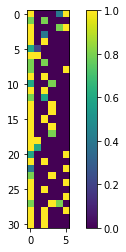

In [ ]:
product_test = 0
selected_lines = np.argwhere(data[:,product_test] > 0).T[0]
plt.imshow(data[selected_lines])
plt.colorbar()
plt.show()

The following code tests the network in order to recommend the most relevant products for a given user. More specifically, for a vector of scores of the acquired products, the RBM returns the products that this user could like. Here,  we selected the two first indications by excluding the already acquired products.

In [ ]:
test_set = np.zeros(number_of_items)
test_set[product_test] = 1

test_set = [0,1,0,0,0,0]

#Here we test a single sample
result_hidden_layer = rbm_model.transform([test_set])[0]
weight_matrix = rbm_model.components_

result = np.matmul(weight_matrix.T,result_hidden_layer)
recomended_products = np.argsort(result)[::-1]
recomended_products = [product for product in recomended_products 
                       if product != product_test]
print ("The two recommended product, in drecreasing order, are: " + 
       str(recomended_products[0:2]) + '.')


The two recommended product, in drecreasing order, are: [3, 4].


## License

This Deep Learning Tutorial is licensed under a Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 (CC BY-NC-ND 4.0) International License.

## Acknowledgments
Henrique F. de Arruda acknowledges FAPESP for sponsorship (grant no. 2018/10489-0). H. F. de Arruda also thanks Soremartec S.A. and Soremartec Italia, Ferrero Group, for partial financial support (from 1st July 2021). His funders had no role in study design, data collection, and analysis, decision to publish, or manuscript preparation. Alexandre Benatti thanks Coordenação de Aperfeiçoamento de Pessoal de Nível Superior - Brasil (CAPES) - Finance Code 001. Luciano da F. Costa thanks CNPq (grant no. 307085/2018-0) and FAPESP (proc. 15/22308-2) for sponsorship. César H. Comin thanks FAPESP (Grant Nos. 2018/09125-4 and 2021/12354-8) for financial support. This work has been supported also by FAPESP grants 11/50761-2 and 15/22308-2.